In [64]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=32, optimizer_generator = SGD(0.0001, momentum=.9), 
                optimizer_discriminator = SGD(0.0005, momentum=.9), optimizer_autoencoder = Adam(0.001)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        #encoder.add(GlobalAvgPool3D())
        encoder.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Flatten())
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dropout(0.3))
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dropout(0.3))
        encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
        decoder.add(Dense(1024, activation='relu', input_dim=encoded_dim))
        decoder.add(Dropout(0.3))
        decoder.add(Dense(1024, activation='relu'))
        decoder.add(Dropout(0.3))
        decoder.add(Dense(6*12*12, activation='relu'))
        decoder.add(Dropout(0.3))
        #decoder.add(Reshape([12*24*24,1]))
        #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
        #decoder.add(Permute((2,1)))
        decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(1024, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(1024, activation="relu"))
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")

        discriminator=self._buildDiscriminator(encoded_dim)
        discriminator.trainable = False
        generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
        generator.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator.trainable = True
        discriminator.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(decoder_input, discriminator2(decoder(decoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
            discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
            discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history=0
            generator_history=0
            
            #discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            #generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(fake_latent, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)
            
            if epoch == 1:
                loss_min = autoencoder_history
            
            if epoch > 50 and autoencoder_history < loss_min:
                loss_min = autoencoder_history
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
                
            
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  AE_loss_min: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, loss_min, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [ ]:
import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../Training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

In [65]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

model = AAE(encoded_dim=256)

batch_size=16
n_epochs=500
seed=42
np.random.seed(42)

history = model.train(train_set, batch_size, n_epochs, len(img_ls))

Epoch--1
AE_loss: 0.0305  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--2
AE_loss: 0.0317  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--3
AE_loss: 0.0252  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--4
AE_loss: 0.0282  D1_loss:0.000   D2_loss:0.693   G1_loss:0.000   G2_loss:0.693
Epoch--5
AE_loss: 0.0301  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--6
AE_loss: 0.0251  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--7
AE_loss: 0.0271  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--8
AE_loss: 0.0267  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--9
AE_loss: 0.0264  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--10
AE_loss: 0.0269  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--11
AE_loss: 0.0280  D1_loss:0.000   D2_loss:0.692   G1_loss:0.000   G2_loss:0.693
Epoch--12
AE_loss: 0.0253  D1_

Epoch--92
AE_loss: 0.0246  D1_loss:0.000   D2_loss:0.682   G1_loss:0.000   G2_loss:0.695
Epoch--93
AE_loss: 0.0246  D1_loss:0.000   D2_loss:0.681   G1_loss:0.000   G2_loss:0.696
Epoch--94
AE_loss: 0.0255  D1_loss:0.000   D2_loss:0.680   G1_loss:0.000   G2_loss:0.696
Epoch--95
AE_loss: 0.0250  D1_loss:0.000   D2_loss:0.680   G1_loss:0.000   G2_loss:0.695
Epoch--96
AE_loss: 0.0249  D1_loss:0.000   D2_loss:0.681   G1_loss:0.000   G2_loss:0.693
Epoch--97
AE_loss: 0.0245  D1_loss:0.000   D2_loss:0.680   G1_loss:0.000   G2_loss:0.696
Epoch--98
AE_loss: 0.0239  D1_loss:0.000   D2_loss:0.680   G1_loss:0.000   G2_loss:0.694
Epoch--99
AE_loss: 0.0233  D1_loss:0.000   D2_loss:0.685   G1_loss:0.000   G2_loss:0.684
Epoch--100
AE_loss: 0.0246  D1_loss:0.000   D2_loss:0.679   G1_loss:0.000   G2_loss:0.700
Epoch--101
AE_loss: 0.0238  D1_loss:0.000   D2_loss:0.679   G1_loss:0.000   G2_loss:0.700
Epoch--102
AE_loss: 0.0277  D1_loss:0.000   D2_loss:0.678   G1_loss:0.000   G2_loss:0.700
Epoch--103
AE_loss

Epoch--184
AE_loss: 0.0169  D1_loss:0.000   D2_loss:0.671   G1_loss:0.000   G2_loss:0.693
Epoch--185
AE_loss: 0.0173  D1_loss:0.000   D2_loss:0.672   G1_loss:0.000   G2_loss:0.691
Epoch--186
AE_loss: 0.0182  D1_loss:0.000   D2_loss:0.671   G1_loss:0.000   G2_loss:0.688
Epoch--187
AE_loss: 0.0191  D1_loss:0.000   D2_loss:0.673   G1_loss:0.000   G2_loss:0.679
Epoch--188
AE_loss: 0.0180  D1_loss:0.000   D2_loss:0.673   G1_loss:0.000   G2_loss:0.686
Epoch--189
AE_loss: 0.0200  D1_loss:0.000   D2_loss:0.668   G1_loss:0.000   G2_loss:0.692
Epoch--190
AE_loss: 0.0183  D1_loss:0.000   D2_loss:0.669   G1_loss:0.000   G2_loss:0.696
Epoch--191
AE_loss: 0.0183  D1_loss:0.000   D2_loss:0.668   G1_loss:0.000   G2_loss:0.692
Epoch--192
AE_loss: 0.0213  D1_loss:0.000   D2_loss:0.671   G1_loss:0.000   G2_loss:0.680
Epoch--193
AE_loss: 0.0183  D1_loss:0.000   D2_loss:0.676   G1_loss:0.000   G2_loss:0.674
Epoch--194
AE_loss: 0.0194  D1_loss:0.000   D2_loss:0.669   G1_loss:0.000   G2_loss:0.688
Epoch--195

Epoch--276
AE_loss: 0.0171  D1_loss:0.000   D2_loss:0.656   G1_loss:0.000   G2_loss:0.684
Epoch--277
AE_loss: 0.0185  D1_loss:0.000   D2_loss:0.655   G1_loss:0.000   G2_loss:0.691
Epoch--278
AE_loss: 0.0193  D1_loss:0.000   D2_loss:0.651   G1_loss:0.000   G2_loss:0.692
Epoch--279
AE_loss: 0.0164  D1_loss:0.000   D2_loss:0.654   G1_loss:0.000   G2_loss:0.691
Epoch--280
AE_loss: 0.0179  D1_loss:0.000   D2_loss:0.654   G1_loss:0.000   G2_loss:0.687
Epoch--281
AE_loss: 0.0161  D1_loss:0.000   D2_loss:0.659   G1_loss:0.000   G2_loss:0.681
Epoch--282
AE_loss: 0.0184  D1_loss:0.000   D2_loss:0.660   G1_loss:0.000   G2_loss:0.679
Epoch--283
AE_loss: 0.0166  D1_loss:0.000   D2_loss:0.664   G1_loss:0.000   G2_loss:0.684
Epoch--284
AE_loss: 0.0178  D1_loss:0.000   D2_loss:0.651   G1_loss:0.000   G2_loss:0.685
Epoch--285
AE_loss: 0.0176  D1_loss:0.000   D2_loss:0.658   G1_loss:0.000   G2_loss:0.689
Epoch--286
AE_loss: 0.0189  D1_loss:0.000   D2_loss:0.649   G1_loss:0.000   G2_loss:0.689
Epoch--287

Epoch--368
AE_loss: 0.0189  D1_loss:0.000   D2_loss:0.627   G1_loss:0.000   G2_loss:0.677
Epoch--369
AE_loss: 0.0188  D1_loss:0.000   D2_loss:0.632   G1_loss:0.000   G2_loss:0.680
Epoch--370
AE_loss: 0.0178  D1_loss:0.000   D2_loss:0.632   G1_loss:0.000   G2_loss:0.682
Epoch--371
AE_loss: 0.0162  D1_loss:0.000   D2_loss:0.627   G1_loss:0.000   G2_loss:0.682
Epoch--372
AE_loss: 0.0178  D1_loss:0.000   D2_loss:0.635   G1_loss:0.000   G2_loss:0.684
Epoch--373
AE_loss: 0.0173  D1_loss:0.000   D2_loss:0.625   G1_loss:0.000   G2_loss:0.681
Epoch--374
AE_loss: 0.0173  D1_loss:0.000   D2_loss:0.630   G1_loss:0.000   G2_loss:0.676
Epoch--375
AE_loss: 0.0182  D1_loss:0.000   D2_loss:0.632   G1_loss:0.000   G2_loss:0.675
Epoch--376
AE_loss: 0.0166  D1_loss:0.000   D2_loss:0.634   G1_loss:0.000   G2_loss:0.678
Epoch--377
AE_loss: 0.0178  D1_loss:0.000   D2_loss:0.625   G1_loss:0.000   G2_loss:0.675
Epoch--378
AE_loss: 0.0188  D1_loss:0.000   D2_loss:0.633   G1_loss:0.000   G2_loss:0.675
Epoch--379

Epoch--460
AE_loss: 0.0171  D1_loss:0.000   D2_loss:0.599   G1_loss:0.000   G2_loss:0.709
Epoch--461
AE_loss: 0.0178  D1_loss:0.000   D2_loss:0.584   G1_loss:0.000   G2_loss:0.716
Epoch--462
AE_loss: 0.0179  D1_loss:0.000   D2_loss:0.579   G1_loss:0.000   G2_loss:0.710
Epoch--463
AE_loss: 0.0152  D1_loss:0.000   D2_loss:0.598   G1_loss:0.000   G2_loss:0.697
Epoch--464
AE_loss: 0.0165  D1_loss:0.000   D2_loss:0.596   G1_loss:0.000   G2_loss:0.679
Epoch--465
AE_loss: 0.0158  D1_loss:0.000   D2_loss:0.607   G1_loss:0.000   G2_loss:0.670
Epoch--466
AE_loss: 0.0173  D1_loss:0.000   D2_loss:0.607   G1_loss:0.000   G2_loss:0.662
Epoch--467
AE_loss: 0.0175  D1_loss:0.000   D2_loss:0.605   G1_loss:0.000   G2_loss:0.660
Epoch--468
AE_loss: 0.0166  D1_loss:0.000   D2_loss:0.591   G1_loss:0.000   G2_loss:0.660
Epoch--469
AE_loss: 0.0182  D1_loss:0.000   D2_loss:0.611   G1_loss:0.000   G2_loss:0.670
Epoch--470
AE_loss: 0.0187  D1_loss:0.000   D2_loss:0.585   G1_loss:0.000   G2_loss:0.685
Epoch--471

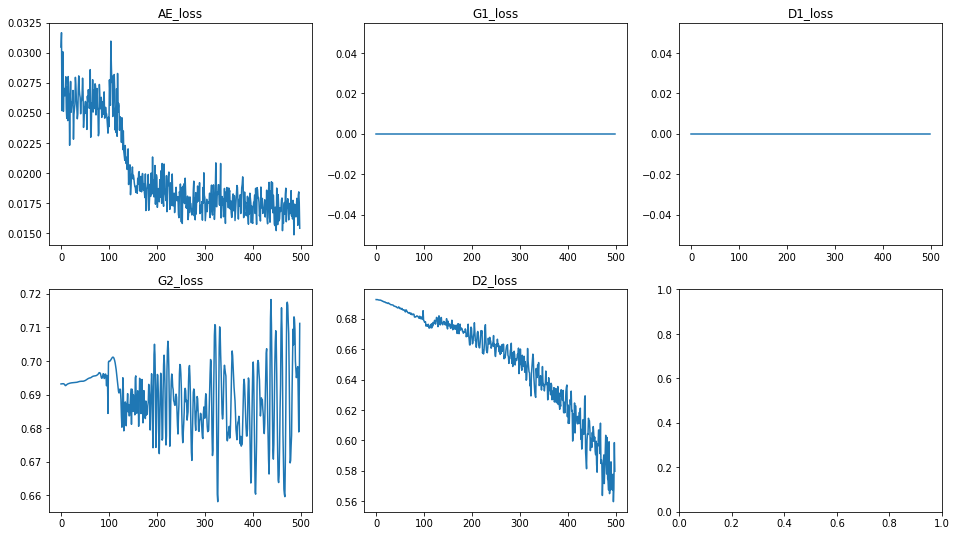

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [67]:
image = train_set[-3].reshape((1,48,96,96,1))
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

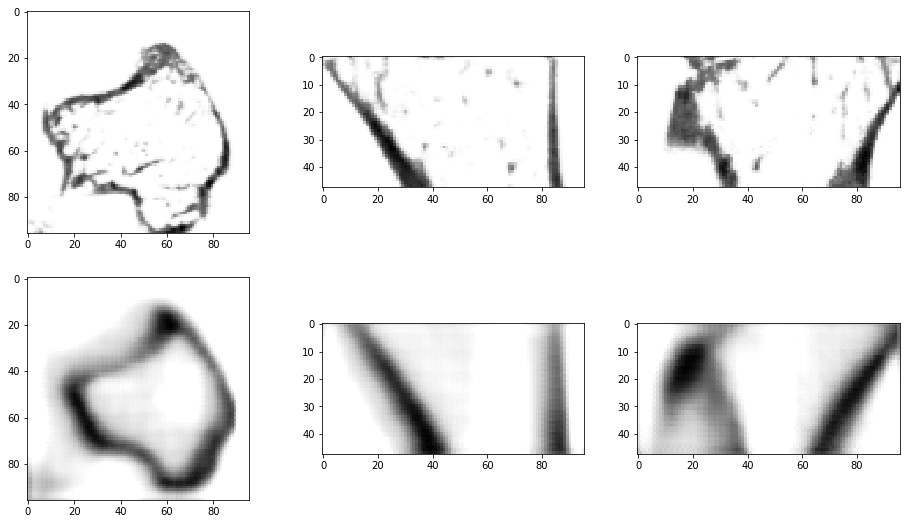

In [68]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [75]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_96 (Conv3D)           (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 12, 24, 24, 64)    55360     
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 6, 12, 12, 128)  

In [74]:
model.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_100 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_101 (Dense)            (None, 13824)             3552768   
_________________________________________________________________
reshape_8 (Reshape)          (None, 3, 6, 6, 128)      0         
_________________________________________________________________
conv3d_transpose_56 (Conv3DT (None, 3, 6, 6, 64)       221248    
_________________________________________________________________
conv3d_transpose_57 (Conv3DT (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_transpose_58 (Conv3DT (None, 6, 12, 12, 32)   

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________
